In [58]:
import os
from datetime import datetime
import folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Point, LineString
from geographiclib.geodesic import Geodesic
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from utils import read_l3, get_sensor_grid
import utils_plots

from pyffp import calc_footprint_FFP as myfootprint
from pyffp import calc_footprint_FFP_climatology as myfootprintclim

from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf
import geopy
from geopy.distance import geodesic

plt.style.use('dark_background')

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2024-04-09.csv' # linux
# filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L3_2024-04-09.csv" # windows
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L3_2024-08-12_ch4gapfilled.csv" # windows
# filepath = os.path.join(os.getcwd(), 'US-AMS', 'US-AMS_HH_202205241000_202312201430.csv')
l3 = read_l3(filepath)
l3

# predictors = 'baseflux'
# filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
# rf = read_l3(filepath).add_suffix('_RF')

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L1_fluxnet_2024-01-30.csv'
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L1_fluxnet_2024-01-30.csv"
l1_fluxnet = read_l3(filepath)

l3['V_SIGMA'] = l1_fluxnet.loc[l1_fluxnet.index == l3.index, 'V_SIGMA']
# l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':]], axis=1)

soil_dateformat = 'yyyy-mm-dd HH:MM:SS+00.00' # from ATMOS484 package

## Get geodataframe of soil sensor locations derived from logger locations

In [59]:
dataloggers, sensors, origin = get_sensor_grid()

zones = sensors.dissolve(by=['zone'], as_index=False)
# zones.drop(columns=['serial', 'port', 'logger', 'teros_num', 'status'])

zonesm = zones.to_crs(3174)
# zonesm.geometry = zonesm.geometry.convex_hull.buffer(distance=6.25, cap_style=1, quad_segs=1)
zonesm.geometry = zonesm.geometry.convex_hull.apply(lambda g: g.buffer(distance=6.25, cap_style=3, join_style=2))

zones = zonesm.to_crs(4326)

# utils_plots.plot_sensor_grid(dataloggers, sensors, zones)

Azimuth from logger 0 to 3 = -66.67909064882072
Azimuth from logger 7 to 10 = -66.51445741226922
Origin = (41.70131583022141, -87.99745859087017)


## Read Zentra soil sensor data, partition into zones

In [60]:
# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L0_2024-04-09_biomet.csv'
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L0_2024-04-09_biomet.csv"
met = read_l3(filepath, datecol='datetime')

# df = met.loc[datestart:dateend, :]

df = met

def read_soil(df, column):
    df = df.loc[:, df.columns.str.match(f'{column}_([0-9]+)([0-9]+)(?!cm)')]
    df = df.melt(var_name='sensor', value_name=column, ignore_index=False)
    xy = df.loc[:, 'sensor'].str.extract(f'{column}([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
    df = pd.concat([df, xy], axis=1)
    df = df.merge(sensors[['x','y','lat','lon']], on=['x','y']).set_index(df.index)
    return df

soilT = df.loc[:, df.columns.str.match('Tsoil_([0-9]+)([0-9]+)(?!cm)')]

## Make dataframe of soilT

soilT = soilT.melt(var_name='Tsoil_sensor', value_name='Tsoil', ignore_index=False)

xy = soilT.loc[:, 'Tsoil_sensor'].str.extract('Tsoil_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilT = pd.concat([soilT, xy], axis=1)

soilT = soilT.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilT.index)

soilM = df.loc[:, df.columns.str.match('SWC_([0-9]+)([0-9]+)(?!cm)')]
soilM = soilM.melt(var_name='SWC_sensor', value_name='SWC', ignore_index=False)

xy = soilM.loc[:, 'SWC_sensor'].str.extract('SWC_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilM = pd.concat([soilM, xy], axis=1)

soilM = soilM.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilM.index)

soil = pd.concat([soilT, soilM[['SWC', 'SWC_sensor']]], axis=1)
soil.loc[:, 'date'] = soil.index
soil = gpd.GeoDataFrame(soil, 
                        geometry=gpd.points_from_xy(soil['lon'], soil['lat']),
                        crs=4326).sort_values(by=['date','y','x'])

soil = soil.sort_values(by=['date','y','x'])

monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')

zones = zones.merge(soil.groupby('zone')[['Tsoil', 'SWC']].mean(), on='zone')

C:\Users\ottob\AppData\Local\Temp\ipykernel_12344\1402061183.py:44: FutureWarning: The provided callable <function mean at 0x00000268BBB62660> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')


# Fine timescale footprints (hopefully)

In [102]:
soil = soil.loc[l3.index[0]:l3.index[-1], :]
monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
monthly
weekly = soil.groupby([soil.date.dt.to_period('W'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
daily3 = soil.groupby([soil.date.dt.to_period('3D'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
soilt = daily3

In [ ]:
z_tower = 4
hei = 1.5
z0t = 0.15 * hei
d = 0.67 * hei

domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 200
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1
weeks = pd.Series(l3.index.to_period('W').to_timestamp().strftime('%Y-%m-%d')).unique()
periods = pd.DataFrame({'start_time': soilt.index.start_time.strftime('%Y-%m-%d').unique(), 'end_time': soilt.index.end_time.strftime('%Y-%m-%d').unique()})

# %%capture footprint_output
for timeperiod in periods['start_time']:
    start_time = timeperiod
    end_time = periods.loc[periods['start_time']==start_time ,'end_time'].values[0]
    print(f'Calculating footprint for {start_time} - {end_time}')

    df = l3.loc[start_time:end_time, :]
    df = df.loc[df['L'].notna()]
    olt = df['L'].tolist()
    sigmavt = df['V_SIGMA'].tolist()
    ustart = df['u.'].tolist()
    wind_dirt = df['wind_dir'].tolist()
    
    ht = 750 * np.ones(len(df))
    ht = ht.tolist()
    zmt = (z_tower - d) * np.ones(len(df))
    zmt = zmt.tolist()
    # print(zmt)
    # print(df)
    fluxspp = ['ch4_flux', 'co2_flux', 'LE',]
    # fluxspp = ['ch4_flux',]
    # generate footprints
    FFP = myfootprintclim.FFP_climatology(
        zm=zmt,
        z0=z0t,
        umean=None,
        h=ht,
        ol=olt,
        sigmav=sigmavt,
        ustar=ustart,
        wind_dir=wind_dirt,
        domain=domaint,
        nx=nxt,
        rs=rst,
        fig = 0,
        figsave_path = f'./output/ATMOS_FFP_{datetime.now().strftime("%Y-%m-%d")}_{end_time}.png',
        # yearmonth = yearmonth,
        smooth_data=1,
        timeseries=True
    )
    print('Georeferencing grids')
    # georeference grids
    x_2d = FFP["x_2d"]
    y_2d = FFP["y_2d"]
    # set the origin at ATMOS flux tower
    origin_lon = -87.996285
    origin_lat = 41.701827
    x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
    y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat
    
    # prepare contour inputs
    clevs = FFP["fr"][::-1]
    clevs = [clev for clev in clevs if clev is not None]
    levs = [clev for clev in clevs]
    fs = FFP["fclim_2d"]
    cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
    f = fs[0]
    c = cs[0]
    cc = [c]*len(levs)

    print('Building footprint time series')
    ft = FFP['ftime'].astype(np.float32)
    fp = os.path.join(os.getcwd(), 'output', 'fwf')
    print(f'fs: {fs.shape}')
    print(f'ft: {ft.shape}')
    
    for fluxsp in fluxspp:
        print(f'Getting {fluxsp}')
        fv = df[fluxsp].to_numpy().astype(np.float32)
        print(f'fv: {fv.shape}')
        
        print('Calculating footprint-weighted flux map')
        fwf = (ft * fv).sum(axis=0) / np.sum(ft, axis=0)
        print(f'fwf: {fwf.shape}')
        
        print('Saving results')
        np.save(os.path.join(fp, f'fwf_{fluxsp}_3daily_{end_time}'), fwf)
    
        # FWFS = gpd.GeoDataFrame(np.ravel(fwf), columns = ['f'], 
        #                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
        #                         crs=4326)
        # FWFS = FWFS.to_crs(3174)
        # FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))
        # FWFS = FWFS.to_crs(4326)
        
        # print('Finding fluxes in zones')
        # # monthly.loc[yearmonth, f'f_{fluxsp}_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].mean() for i in range(16)]
        # weekly.loc[soilt.index.iloc[t], f'f_{fluxsp}_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].mean() for i in range(16)]
        # print('Next month')
        # FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['f'], 
        #                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
        #                         crs=4326)
        # fig, ax = plt.subplots()
        # FWFS.plot(column='f', 
        #           legend = True,   
        #           vmin = -0.02, 
        #           vmax = 0.02,
        #           legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
        #           ax=ax)
        # plt.show()
        # zones.loc[:, f'fsum_{fluxsp}'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].mean() for i in range(16)]
        
    print('Saving all results')
    fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos_zones_weekly_{datetime.now().strftime("%Y%m%d")}.csv'
    output = weekly

Calculating footprint for 2022-05-24 - 2022-05-26

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  108
Calculating footprint  6  of  108
Calculating footprint  11  of  108
Calculating footprint  16  of  108
Calculating footprint  21  of  108
Calculating footprint  26  of  108
Calculating footprint  31  of  108
Calculating footprint  36  of  108
Calculating footprint  41  of  108
Calculating footprint  46  of  108
Calculating footprint  51  of  108
Calculating footprint  56  of  108
Calculating footprint  61  of  108
Calculating footprint  66  of  108
Calculating footprint  71  of  108
Calculating footprint  76  of  108
Calculating footprint  81  of  108
Calculating footprint  86  of  108
Calculating footprint  91  of  108
Calculating footprint  96  of  108
Calculating footprint  101  of  108
Calculating footprint  106  of  108
Georeferencing grids
Building footprint time series
fs: (201, 201)
ft: (201, 201, 108)
Getting ch4_flux
fv

C:\Users\ottob\AppData\Local\Temp\ipykernel_12344\1147852305.py:87: RuntimeWarning: invalid value encountered in divide
  fwf = (ft * fv).sum(axis=0) / np.sum(ft, axis=0)


Calculating footprint  36  of  100
Calculating footprint  41  of  100
Calculating footprint  46  of  100
Calculating footprint  51  of  100
Calculating footprint  56  of  100
Calculating footprint  61  of  100
Calculating footprint  66  of  100
Calculating footprint  71  of  100
Calculating footprint  76  of  100
Calculating footprint  81  of  100
Calculating footprint  86  of  100
Calculating footprint  91  of  100
Calculating footprint  96  of  100
Georeferencing grids
Building footprint time series
fs: (201, 201)
ft: (201, 201, 100)
Getting ch4_flux
fv: (100,)
Calculating footprint-weighted flux map
fwf: (201, 100)
Saving results
Getting co2_flux
fv: (100,)
Calculating footprint-weighted flux map
fwf: (201, 100)
Saving results
Getting LE
fv: (100,)
Calculating footprint-weighted flux map
fwf: (201, 100)
Saving results
Saving all results
Calculating footprint for 2022-05-26 - 2022-05-28

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1

# Monthly footprints

In [4]:
# datestart = '2022-05'
# dateend = datestart

# ### Site parameters
# z_tower = 4
# hei = 1.5
# z0t = 0.15 * hei
# d = 0.67 * hei

# df = l3.loc[datestart:dateend]
# df = df.loc[df['L'].notna()]

# ht = 750 * np.ones(len(df))
# ht = ht.tolist()

# zmt = (z_tower - d) * np.ones(len(df))
# zmt = zmt.tolist()

# olt = df['L'].tolist()
# sigmavt = df['V_SIGMA'].tolist()
# ustart = df['u.'].tolist()
# wind_dirt = df['wind_dir'].tolist()
# domaint = [-100.0, 100.0, -100.0, 100.0]
# nxt = 200
# # rst = [20.0, 40.0, 60.0, 80.0]
# rst = [50.0, 80.0]

# fig = 0

In [5]:
def calc_FFP_monthly(l3, soil, zones, figsave_path = './output/ATMOS_FFP_test.png'):
    
    monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')

    z_tower = 4
    hei = 1.5
    z0t = 0.15 * hei
    d = 0.67 * hei

    domaint = [-100.0, 100.0, -100.0, 100.0]
    nxt = 200
    # rst = [20.0, 40.0, 60.0, 80.0]
    rst = [50.0, 80.0]

    fig = 1
    
    for yearmonth in l3.date.dt.to_period('M').astype(str).unique():
        
        print(f'Calculating footprint for {yearmonth}')
        df = l3.loc[yearmonth]
        df = df.loc[df['L'].notna()]
        olt = df['L'].tolist()
        sigmavt = df['V_SIGMA'].tolist()
        ustart = df['u.'].tolist()
        wind_dirt = df['wind_dir'].tolist()
        
        ht = 750 * np.ones(len(df))
        ht = ht.tolist()
        zmt = (z_tower - d) * np.ones(len(df))
        zmt = zmt.tolist()


#         monthly = l3.groupby([l3.date.dt.to_period])['FCH4', 'FCH4_F_RF', 'NEE_F', 'LE_F'].mean()
        
        # generate footprints
        FFP = myfootprintclim.FFP_climatology(
            zm=zmt,
            z0=z0t,
            umean=None,
            h=ht,
            ol=olt,
            sigmav=sigmavt,
            ustar=ustart,
            wind_dir=wind_dirt,
            domain=domaint,
            nx=nxt,
            rs=rst,
            fig = 0,
            figsave_path = f'./output/ATMOS_FFP_{datetime.now().strftime("%Y-%m-%d")}_{yearmonth}.png',
            yearmonth = yearmonth,
            smooth_data=1,
            timeseries=True
        )
        print('Georeferencing grids')
        # georeference grids
        x_2d = FFP["x_2d"]
        y_2d = FFP["y_2d"]
        # set the origin at ATMOS flux tower
        origin_lon = -87.996285
        origin_lat = 41.701827
        x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
        y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

        # prepare contour inputs
        clevs = FFP["fr"][::-1]
        clevs = [clev for clev in clevs if clev is not None]
        levs = [clev for clev in clevs]
        fs = FFP["fclim_2d"]
        cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
        f = fs[0]
        c = cs[0]
        cc = [c]*len(levs)

        # fwfs = np.sum(df['FCH4_F_RF']) * fs

        # generate GeoDataFrame of contours
        # fig, ax = plt.subplots(figsize=(10, 8))
        # cp = ax.contour(x_2d_dd, y_2d_dd, fs, levs, colors = cc, linewidths=0.5)
        # gdf = contour_to_gdf(cp)
        # plt.close()

        # print('Building footprint time series')
        ft = FFP['ftime'].astype(np.float32)

        # fs = FFP["fclim_2d"]
        fluxspp = ['ch4_flux', 'co2_flux', 'LE']
        fp = os.path.join(os.getcwd(), 'output', 'fwf')
        for fluxsp in fluxspp:
            print(f'Getting {fluxsp}')
            fv = df[fluxsp].to_numpy().astype(np.float32)
            
            print('Calculating footprint-weighted flux map')
            fwf = (ft * fv[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
            
            print('Saving results')
            np.save(os.path.join(fp, f'fwf_{fluxsp}_{yearmonth}'), fwf)
        
        # FWFS = gpd.GeoDataFrame(np.ravel(fwfm), columns = ['fm'], 
        #                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
        #                         crs=4326)
        # FWFS = FWFS.to_crs(3174)
        # FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))
        # FWFS = FWFS.to_crs(4326)
        
        # print('Finding fluxes in zones')
        # monthly.loc[yearmonth, 'fm_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
        # print('Next month')
        # FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['fm'], 
        #                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
        #                         crs=4326))
    #     fig, ax = plt.subplots()
    #     FWFS.plot(column='fm', 
    #               legend = True, 
    #               vmin = -0.02, 
    #               vmax = 0.02,
    #               legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
    #               ax=ax)

    #     zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
        
    print('Saving all results')
    fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos_zones_{datetime.now().strftime("%Y%m%d")}.csv'
    output = monthly
#     output.to_csv(fp, index=True)
        
    return monthly, FFP

In [6]:
imonth = 0
month = str(monthly.index.unique()[imonth])

# for month in monthly.index.unique():
#     print(str(month))
#     FFP_save_path = f'./output/ATMOS_FFP_{datetime.now().strftime("%Y-%m-%d")}_{str(month)}.png'
#     monthly, FFP = calc_FFP_monthly(l3.loc[str(month):str(month)], soil, zones, figsave_path = FFP_save_path)

monthly, FFP = calc_FFP_monthly(l3.loc['2022-06':'2022-06', :], soil, zones)

C:\Users\ottob\AppData\Local\Temp\ipykernel_21440\2639842705.py:3: FutureWarning: The provided callable <function mean at 0x000001FC63D81E40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')


Calculating footprint for 2022-06

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  837
Calculating footprint  42  of  837
Calculating footprint  83  of  837
Calculating footprint  124  of  837
Calculating footprint  165  of  837
Calculating footprint  206  of  837
Calculating footprint  247  of  837
Calculating footprint  288  of  837
Calculating footprint  329  of  837
Calculating footprint  370  of  837
Calculating footprint  411  of  837
Calculating footprint  452  of  837
Calculating footprint  493  of  837
Calculating footprint  534  of  837
Calculating footprint  575  of  837
Calculating footprint  616  of  837
Calculating footprint  657  of  837
Calculating footprint  698  of  837
Calculating footprint  739  of  837
Calculating footprint  780  of  837
Calculating footprint  821  of  837
Georeferencing grids
Building footprint time series
Getting ch4_flux
Calculating footprint-weighted flux map
Saving results
Getting co2_flux

In [19]:
FFP.keys()

dict_keys(['x_2d', 'y_2d', 'fclim_2d', 'ftime', 'rs', 'fr', 'xr', 'yr', 'n', 'flag_err'])

In [ ]:
FFP['ftime'][3].sum()

In [43]:
FFP['fclim_2d'].sum()

0.8958719007589852

<Axes: >

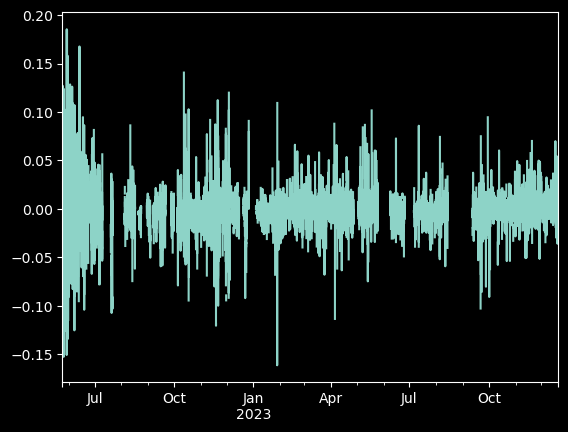

In [35]:
l3.loc[:, 'ch4_flux'].plot()

In [32]:
monthly = read_l3('/home/otto/data/atmos-flux-data/output/csv/atmos_zones_20240409.csv', datecol='date')

M = monthly.merge(zones[['zone', 'geometry']], on='zone', how='left').set_index(monthly.index)
M = gpd.GeoDataFrame(M, geometry = M['geometry'], crs=4326)
M

,date,zone,Tsoil,SWC,fm_mean,geometry
2022-05-01,2022-05-01,0,15.107401,0.371446,NaN,"POLYGON ((-87.99728 41.70120, -87.99756 41.701..."
2022-05-01,2022-05-01,1,15.107401,0.371446,NaN,"POLYGON ((-87.99701 41.70111, -87.99728 41.701..."
2022-05-01,2022-05-01,2,16.393199,0.400718,NaN,"POLYGON ((-87.99673 41.70102, -87.99701 41.701..."
2022-05-01,2022-05-01,3,16.616635,0.415181,NaN,"POLYGON ((-87.99645 41.70093, -87.99673 41.701..."
2022-05-01,2022-05-01,4,16.410205,0.382401,NaN,"POLYGON ((-87.99716 41.70140, -87.99744 41.701..."
...,...,...,...,...,...,...
2023-12-01,2023-12-01,11,4.741039,0.418183,NaN,"POLYGON ((-87.99622 41.70134, -87.99649 41.701..."
2023-12-01,2023-12-01,12,6.192805,0.390089,NaN,"POLYGON ((-87.99692 41.70182, -87.99720 41.701..."
2023-12-01,2023-12-01,13,4.834961,0.396649,NaN,"POLYGON ((-87.99665 41.70173, -87.99692 41.701..."
2023-12-01,2023-12-01,14,4.691994,0.406860,NaN,"POLYGON ((-87.99637 41.70164, -87.99665 41.701..."


In [26]:
monthly.loc['2022-09':'2023-02','Tsoil'].describe()

count    96.000000
mean      7.465164
std       5.973328
min       1.414473
25%       2.524311
50%       5.263149
75%      11.831043
max      18.774669
Name: Tsoil, dtype: float64

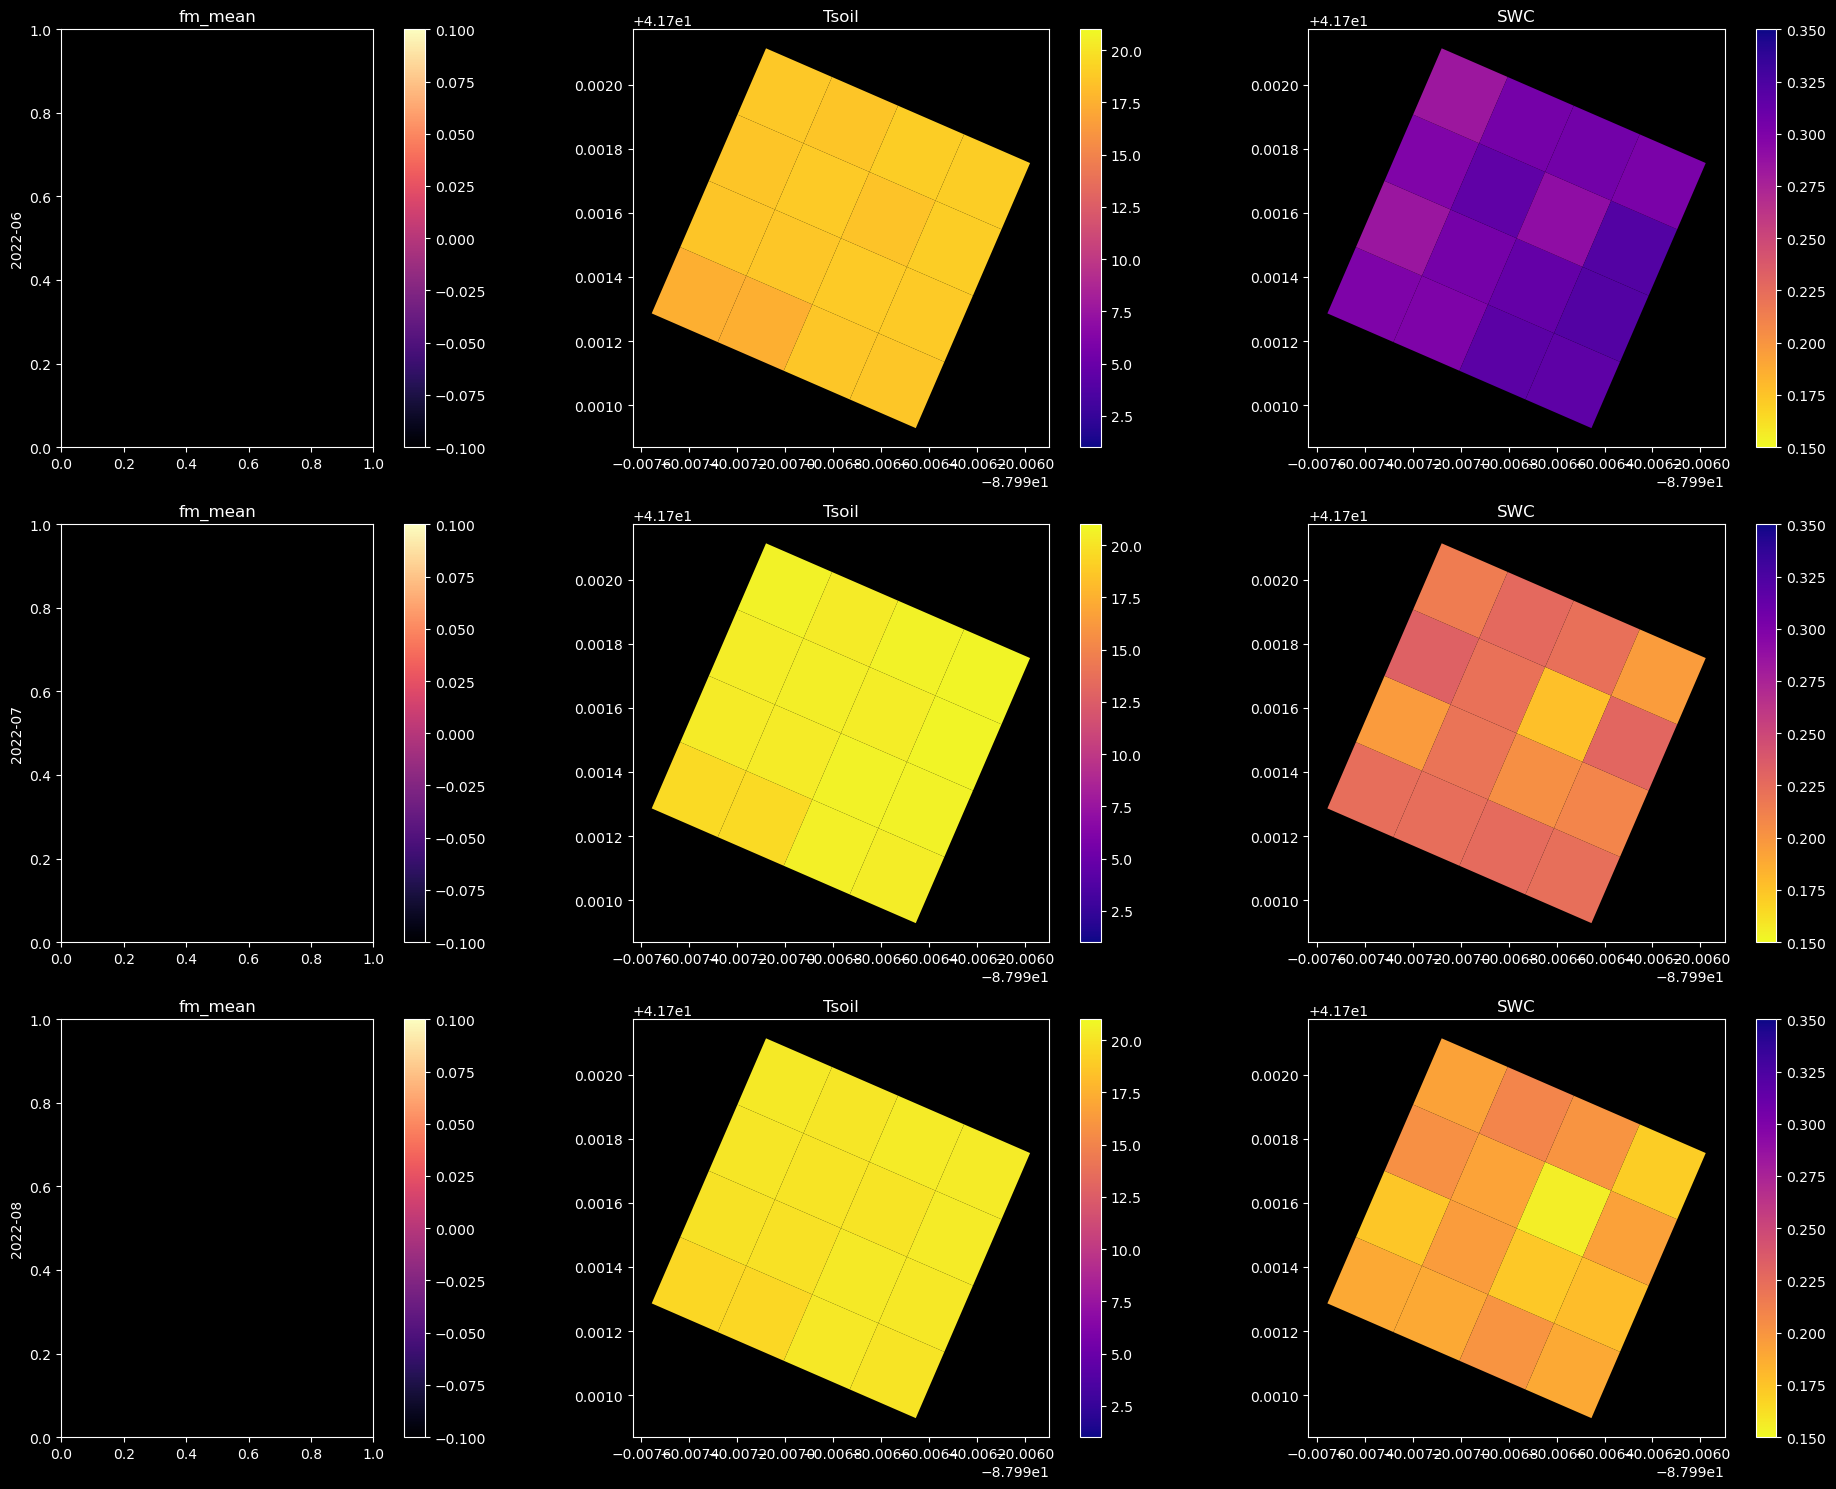

In [27]:
fig, ax = plt.subplots(3,3, figsize = (20,15))

cols = ['fm_mean', 'Tsoil', 'SWC']
cmaps = ['magma', 'plasma', 'plasma_r']
months = monthly.date.dt.to_period('M').astype(str).unique()[]
norms = [plt.Normalize(vmin=monthly['fm_mean'].min(), vmax=monthly['fm_mean'].max()), 
         plt.Normalize(vmin=1, vmax=21), 
         plt.Normalize(vmin=0.15, vmax=0.35), ]
for j in range(len(months)):
    ax[j,0].set_ylabel(months[j])
    for i in range(len(cols)):
        M.loc[months[j],:].plot(column = cols[i], cmap=cmaps[i], legend=True, ax=ax[j,i], norm=norms[i])
        ax[j,i].set_title(cols[i])
# M.loc['2022-09',:].plot(column = 'Tsoil', cmap='inferno', legend=True, ax=ax[1])
# M.loc['2022-09',:].plot(column = 'SWC', cmap='inferno', legend=True, ax=ax[2])
plt.tight_layout()
plt.savefig(f'/home/otto/data/atmos-flux-data/output/atmos_zonesbymon_{datetime.now().strftime("%Y%m%d")}_{months[0]}-to-{months[len(months)-1]}')

In [107]:
monthly.loc[l3.date.dt.to_period('M').astype(str).unique()[6]]

,zone,Tsoil,SWC,fm_mean
date,,,,
2022-11,0,7.262866,0.316156,NaN
2022-11,1,7.262866,0.316156,NaN
2022-11,2,7.196556,0.317326,NaN
2022-11,3,7.473255,0.297987,NaN
2022-11,4,7.576610,0.308419,NaN
2022-11,5,7.197581,0.346242,NaN
2022-11,6,7.319243,0.315987,NaN
2022-11,7,7.733436,0.299969,NaN
2022-11,8,7.530804,0.333670,NaN


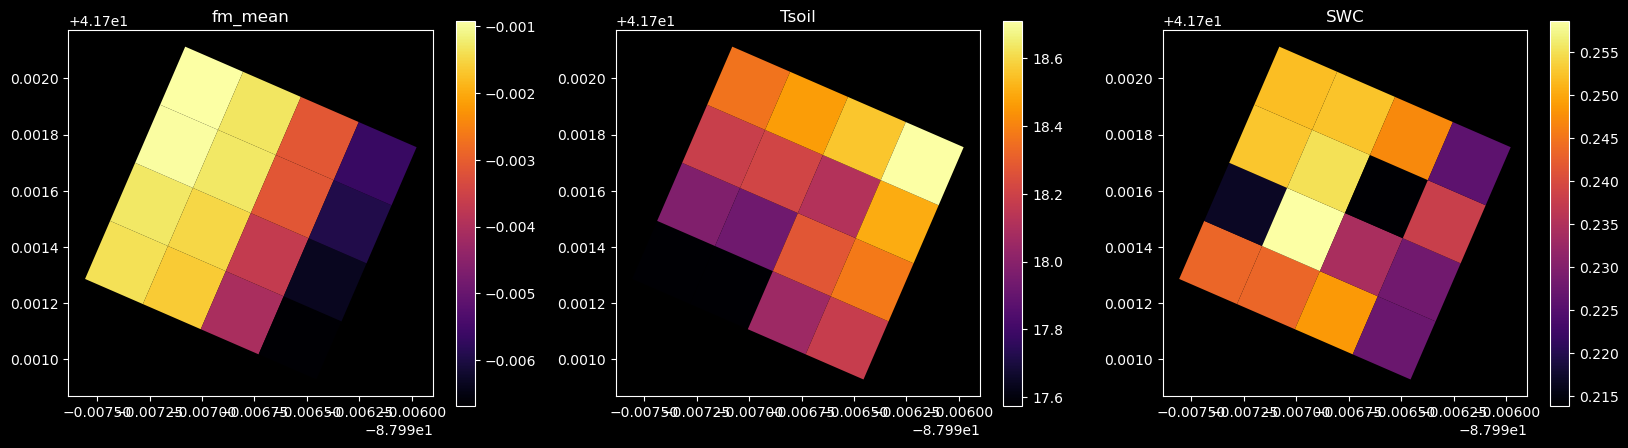

In [83]:
fig, ax = plt.subplots(1,3, figsize = (20,5))
cols = ['fm_mean', 'Tsoil', 'SWC']
for i in range (len(cols)):
    M.loc['2022-09',:].plot(column = cols[i], cmap='inferno', legend=True, ax=ax[i])
    ax[i].set_title(cols[i])
# M.loc['2022-09',:].plot(column = 'Tsoil', cmap='inferno', legend=True, ax=ax[1])
# M.loc['2022-09',:].plot(column = 'SWC', cmap='inferno', legend=True, ax=ax[2])

<Axes: >

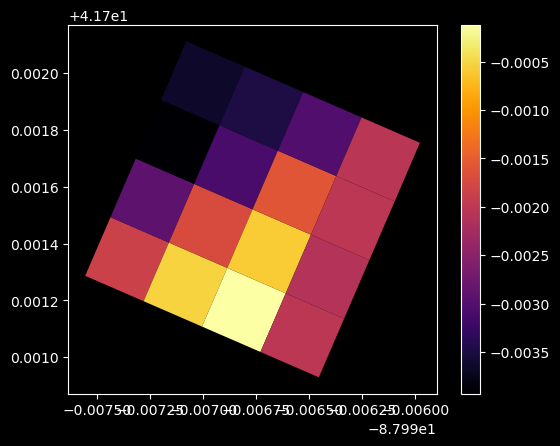

In [23]:
fig, ax = plt.subplots()
monthly.plot(column='fsum_m', cmap='inferno', legend=True, ax = ax)
# FWFS.plot(column = 'fm', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

In [53]:
monthly.loc['2022-05':'2022-07', :]

,zone,Tsoil,SWC,fm_mean
date,,,,
2022-05,0,15.107401,0.371446,0.004154
2022-05,1,15.107401,0.371446,0.002030
2022-05,2,16.393199,0.400718,-0.000703
2022-05,3,16.616635,0.415181,-0.006436
2022-05,4,16.410205,0.382401,0.005843
2022-05,5,16.326840,0.379454,0.003056
2022-05,6,16.258614,0.398088,-0.001530
2022-05,7,16.681564,0.410542,-0.005755
2022-05,8,16.264976,0.371335,0.005604



Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  1058
Calculating footprint  53  of  1058
Calculating footprint  105  of  1058
Calculating footprint  157  of  1058
Calculating footprint  209  of  1058
Calculating footprint  261  of  1058
Calculating footprint  313  of  1058
Calculating footprint  365  of  1058
Calculating footprint  417  of  1058
Calculating footprint  469  of  1058
Calculating footprint  521  of  1058
Calculating footprint  573  of  1058
Calculating footprint  625  of  1058
Calculating footprint  677  of  1058
Calculating footprint  729  of  1058
Calculating footprint  781  of  1058
Calculating footprint  833  of  1058
Calculating footprint  885  of  1058
Calculating footprint  937  of  1058
Calculating footprint  989  of  1058
Calculating footprint  1041  of  1058


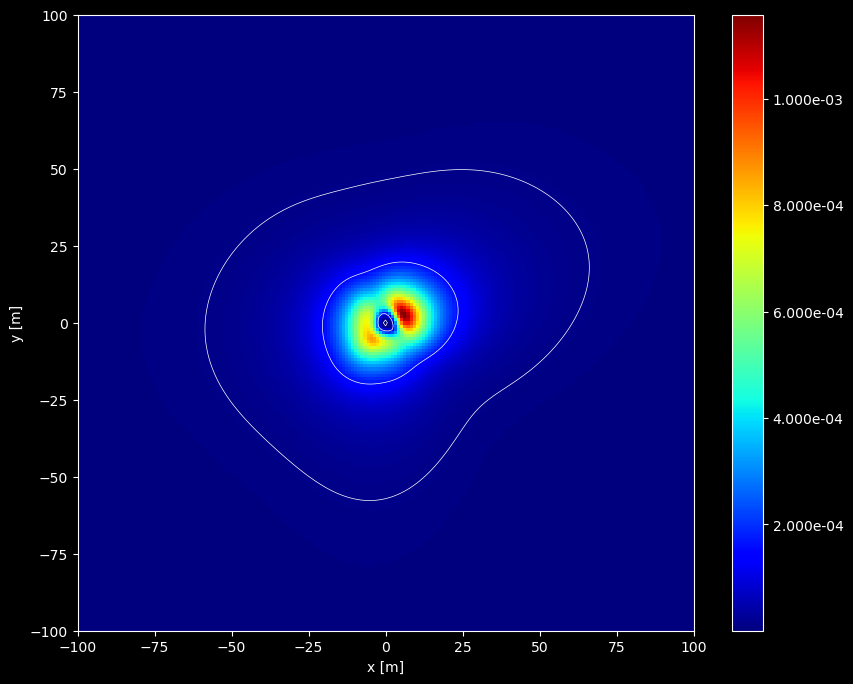

In [13]:
# generate footprints
FFP = myfootprintclim.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1,
    timeseries=True
)

In [44]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at ATMOS flux tower
origin_lon = -87.996285
origin_lat = 41.701827
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

# prepare contour inputs
clevs = FFP["fr"][::-1]
clevs = [clev for clev in clevs if clev is not None]
levs = [clev for clev in clevs]
fs = FFP["fclim_2d"]
cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
f = fs[0]
c = cs[0]
cc = [c]*len(levs)

# fwfs = np.sum(df['FCH4_F_RF']) * fs

In [45]:
# generate GeoDataFrame of contours
fig, ax = plt.subplots(figsize=(10, 8))
cp = ax.contour(x_2d_dd, y_2d_dd, fs, levs, colors = cc, linewidths=0.5)
gdf = contour_to_gdf(cp)
plt.close()

### Footprint-weighted flux map

For each cell i,j, we multiply the half-hourly flux for half-hour *m* (F_EC*m*) by the half-hourly footprint function for that cell i,j (*f_ijm*), then sum that product for all half-hours. We then divide that sum by the sum of the footprint functions for cell i,j over all half-hours (*f_ijm*).

So, we need to access both the flux and footprint footprint for each half-hour.

In [50]:
df = l3.loc['2022-06':'2022-06',:]
ft = FFP['ftime']

# fs = FFP["fclim_2d"]

fv_m = df['ch4_flux'].to_numpy()
fv_c = df['co2_flux'].to_numpy()
fv_w = df['LE'].to_numpy()

In [51]:
fv_m

array([      nan, 0.0618384, 0.0149152, ..., 0.0303275, 0.0476593,
       0.0144327])

In [49]:
fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)

ValueError: operands could not be broadcast together with shapes (585,201,201) (1440,1,1) 

In [18]:
FWFS = gpd.GeoDataFrame(np.ravel(fwfm), columns = ['fm'], 
                        geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                        crs=4326)
FWFS = FWFS.to_crs(3174)

FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))

FWFS = FWFS.to_crs(4326)

# FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['fm'], 
#                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
#                         crs=4326))

<Axes: >

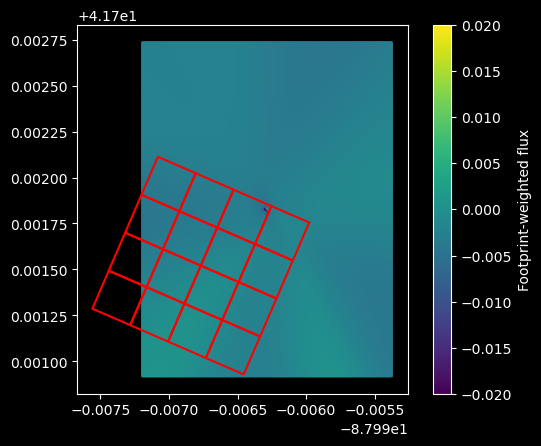

In [19]:
fig, ax = plt.subplots()

FWFS.plot(column='fm', 
          legend = True, 
          vmin = -0.02, 
          vmax = 0.02,
          legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
          ax=ax)

zones.boundary.plot(color = 'red', alpha = 1, ax=ax)

In [36]:
myfootprintclim.plot_footprint(x_2d=x_2d_dd, y_2d=y_2d_dd, fs=fwfm,
                                        show_heatmap=True,clevs=clevs[::-1])

NameError: name 'x_2d_dd' is not defined

Sum footprint-weighted fluxes in each zone

In [22]:
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]

fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos_zones_{datestart}_{datetime.now().strftime("%Y%m%d")}.csv'
output = zones[['zone', 'geometry', 'Tsoil','SWC','fsum_m']]
# output.to_csv(fp, index=False)

In [88]:
monthly.loc[datestart, 'fm_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
monthly

,zone,Tsoil,SWC,fsum,fm_mean
date,,,,,
2022-05,0,15.107401,0.371446,NaN,NaN
2022-05,1,15.107401,0.371446,NaN,NaN
2022-05,2,16.393199,0.400718,NaN,NaN
2022-05,3,16.616635,0.415181,NaN,NaN
2022-05,4,16.410205,0.382401,NaN,NaN
...,...,...,...,...,...
2023-03,11,NaN,NaN,-0.002015,-0.002015
2023-03,12,NaN,NaN,-0.003649,-0.003649
2023-03,13,NaN,NaN,-0.003481,-0.003481


<Axes: >

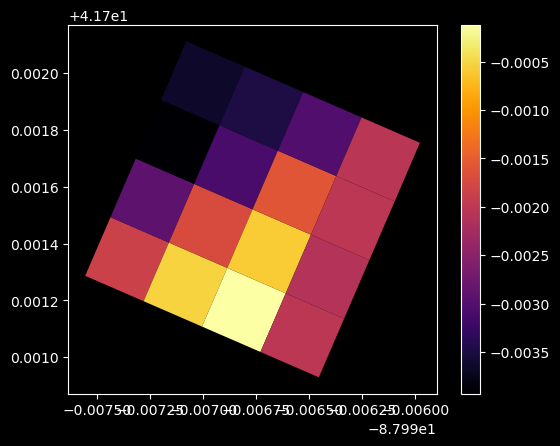

In [23]:
fig, ax = plt.subplots()
zones.plot(column='fsum_m', cmap='inferno', legend=True, ax = ax)
# FWFS.plot(column = 'fm', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

In [75]:
zones

,zone,geometry,logger,serial,status,port,teros_num,x,y,lat,lon,Tsoil,SWC,fsum_m
0,0,"POLYGON ((-87.99728 41.70120, -87.99756 41.701...",1.0,28.0,Active,1,2767,0,0,41.701316,-87.997459,17.445417,0.299912,0.001748
1,1,"POLYGON ((-87.99701 41.70111, -87.99728 41.701...",2.0,17.0,Active,1,2733,2,0,41.701226,-87.997183,17.445417,0.299912,0.001591
2,2,"POLYGON ((-87.99673 41.70102, -87.99701 41.701...",3.0,19.0,Active,1,1983,4,0,41.701137,-87.996907,18.621377,0.317648,0.000420
3,3,"POLYGON ((-87.99645 41.70093, -87.99673 41.701...",4.0,29.0,Active,1,2718,6,0,41.701048,-87.996632,18.649663,0.316163,-0.000488
4,4,"POLYGON ((-87.99716 41.70140, -87.99744 41.701...",1.0,28.0,Active,3,2760,0,2,41.701522,-87.997339,18.535211,0.284072,0.001302
5,5,"POLYGON ((-87.99689 41.70131, -87.99716 41.701...",2.0,17.0,Active,3,2794,2,2,41.701433,-87.997064,18.596282,0.304076,0.001377
6,6,"POLYGON ((-87.99661 41.70122, -87.99689 41.701...",3.0,19.0,Active,3,2709,4,2,41.701344,-87.996788,18.774825,0.313207,0.000440
7,7,"POLYGON ((-87.99634 41.70114, -87.99661 41.701...",4.0,29.0,Active,3,2726,6,2,41.701254,-87.996512,18.822271,0.321825,-0.000580
8,8,"POLYGON ((-87.99704 41.70161, -87.99732 41.701...",5.0,41.0,Active,2,2730,0,4,41.701729,-87.997220,18.517901,0.298866,-0.000506
9,9,"POLYGON ((-87.99677 41.70152, -87.99704 41.701...",5.0,41.0,Active,5,2717,2,4,41.701640,-87.996944,18.734536,0.315364,0.000499


In [328]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_ffp_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [76]:
zones

,zone,geometry,logger,serial,status,port,teros_num,x,y,lat,lon,Tsoil,SWC,fsum_m
0,0,"POLYGON ((-87.99728 41.70120, -87.99756 41.701...",1.0,28.0,Active,1,2767,0,0,41.701316,-87.997459,17.445417,0.299912,0.001748
1,1,"POLYGON ((-87.99701 41.70111, -87.99728 41.701...",2.0,17.0,Active,1,2733,2,0,41.701226,-87.997183,17.445417,0.299912,0.001591
2,2,"POLYGON ((-87.99673 41.70102, -87.99701 41.701...",3.0,19.0,Active,1,1983,4,0,41.701137,-87.996907,18.621377,0.317648,0.000420
3,3,"POLYGON ((-87.99645 41.70093, -87.99673 41.701...",4.0,29.0,Active,1,2718,6,0,41.701048,-87.996632,18.649663,0.316163,-0.000488
4,4,"POLYGON ((-87.99716 41.70140, -87.99744 41.701...",1.0,28.0,Active,3,2760,0,2,41.701522,-87.997339,18.535211,0.284072,0.001302
5,5,"POLYGON ((-87.99689 41.70131, -87.99716 41.701...",2.0,17.0,Active,3,2794,2,2,41.701433,-87.997064,18.596282,0.304076,0.001377
6,6,"POLYGON ((-87.99661 41.70122, -87.99689 41.701...",3.0,19.0,Active,3,2709,4,2,41.701344,-87.996788,18.774825,0.313207,0.000440
7,7,"POLYGON ((-87.99634 41.70114, -87.99661 41.701...",4.0,29.0,Active,3,2726,6,2,41.701254,-87.996512,18.822271,0.321825,-0.000580
8,8,"POLYGON ((-87.99704 41.70161, -87.99732 41.701...",5.0,41.0,Active,2,2730,0,4,41.701729,-87.997220,18.517901,0.298866,-0.000506
9,9,"POLYGON ((-87.99677 41.70152, -87.99704 41.701...",5.0,41.0,Active,5,2717,2,4,41.701640,-87.996944,18.734536,0.315364,0.000499


In [30]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

data = pd.DataFrame({'lat': np.ravel(y_2d_dd),
                     'lon': np.ravel(x_2d_dd),
                     'fwfs': np.ravel(fwfc)})

data = data.loc[data['fwfs'].notna()].to_numpy().tolist()

HeatMap(data).add_to(m)

m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_fwf_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [91]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "SE-Nor"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

map_osm = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
map_osm.add_child(origin)
map_osm.add_child(contours)
map_osm.save('/home/otto/data/atmos-flux-data/output/html/atmos_ffp_osm_2022-06')
map_osm

In [4]:
l3.loc['2022-06-01 09:30', ['FCH4_F_RF']]

FCH4_F_RF    0.088184
Name: 2022-06-01 09:30:00, dtype: object

In [5]:
hh_m = '2022-06-01 09:30'

df = l3.loc[hh_m]

ht = 750

zmt = (z_tower - d)

olt = df['L']
sigmavt = df['V_SIGMA']
ustart = df['u.']
wind_dirt = df['wind_dir']
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 600
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1

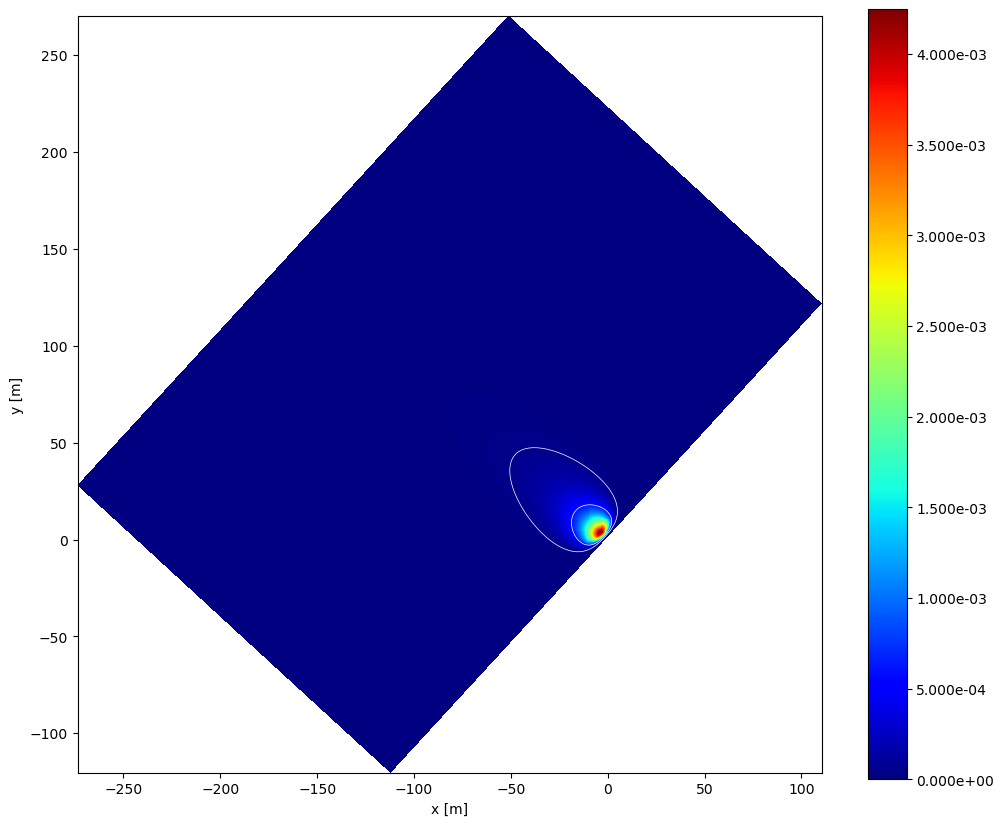

In [6]:
# generate footprints
FFP = myfootprint.FFP(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1
)